### 1. Reusable Cobb Angle Measurement Algorithm

In [1]:
import numpy as np
import cv2 as cv
import pandas as pd
import math

In [ ]:
import numpy as np
import math

def _create_angles_dict(pt, mt, tl):
  """
  pt,mt,tl: tuple(2) that contains: (angle, [idxTop, idxBottom])
  """
  return {
    "pt": {
        "angle": pt[0],
        "idxs": [pt[1][0], pt[1][1]],
    },
    "mt": {
        "angle": mt[0],
        "idxs": [mt[1][0], mt[1][1]],
    },
    "tl": {
        "angle": tl[0],
        "idxs": [tl[1][0], tl[1][1]],
    }
  }

def _isS(p):
    num = len(p)
    ll = np.zeros([num-2,1])
    for i in range(num-2):
        ll[i] = (p[i][1]-p[num-1][1])/(p[0][1]-p[num-1][1]) - (p[i][0]-p[num-1][0])/(p[0][0]-p[num-1][0])

    flag = np.sum(np.sum(np.dot(ll,ll.T))) != np.sum(np.sum(abs(np.dot(ll,ll.T))))
    return(flag)

def cobb_angle_cal(landmark_xy, image_shape):
  """
  `landmark_xy`: number[n]. [x1,x2,...,xn,y1,y2,...,yn], where
  - `n` is even.
  - 0 <= x <= W
  - 0 <= y <= H
  `image_shape`: (HEIGHT, WIDTH, CHANNELS) *only HEIGHT is important

  Returns: Tuple(4): cobb_angles_list, angles_with_pos, curve_type, midpoint_lines.
  - `cobb_angles_list` - For evaluating with ground-truth: ex. [0.50, 0.11, 0.33].
  - `angles_with_pos` - dict of "pt", "mt", "tl", each with values for "angle" and "idxs".
  - `curve_type` - "S" or "C".
  - `midpoint_lines` - list of mid point line coordinates: ex. [[[x,y][x,y]], [[x,y][x,y]], ...].
  """
  landmark_xy = list(landmark_xy) # input is list
  ap_num = int(len(landmark_xy)/2) # number of points
  vnum = int(ap_num / 4) # number of verts

  first_half = landmark_xy[:ap_num]
  second_half = landmark_xy[ap_num:]

  # Values this function returns
  cob_angles = np.zeros(3)
  angles_with_pos = {}
  curve_type = None

  # Midpoints (2 points per vertebra)
  mid_p_v = []
  for i in range(int(len(landmark_xy)/4)):
      x = first_half[2*i: 2*i+2]
      y = second_half[2*i: 2*i+2]
      row = [(x[0] + x[1]) / 2, (y[0] + y[1]) / 2]
      mid_p_v.append(row)

  mid_p = []
  for i in range(int(vnum)):
      x = first_half[4*i: 4*i+4]
      y = second_half[4*i: 4*i+4]
      point1 = [(x[0] + x[2]) / 2, (y[0] + y[2]) / 2]
      point2 = [(x[3] + x[1]) / 2, (y[3] + y[1]) / 2]
      mid_p.append(point1)
      mid_p.append(point2)

  # Line and Slope
  vec_m = []
  for i in range(int(len(mid_p)/2)):
    points = mid_p[2*i: 2*i+2]
    row = [points[1][0]-points[0][0], points[1][1]-points[0][1]]
    vec_m.append(row)

  mod_v = []
  for i in vec_m:
      row = [i[0]*i[0], i[1]*i[1]]
      mod_v.append(row)

#   dot_v = np.dot(np.matrix(vec_m), np.matrix(vec_m).T)
#   mod_v = np.sqrt(np.sum(np.matrix(mod_v), axis=1))

#   dot_v = np.dot(np.matrix(vec_m), np.matrix(vec_m).T)

  slopes = []
  for i in vec_m:
    if i[0] != 0:  # 나누기 전에 0인지 확인
        slope = i[1] / i[0]
    else:
        slope = float('inf')  # 기울기를 무한대로 설정 (수직선)
    slopes.append(slope)

  angles = np.clip(dot_v/np.dot(mod_v, mod_v.T), -1, 1)
  angles = np.arccos(angles)

  maxt = np.amax(angles, axis = 0)
  pos1 = np.argmax(angles, axis = 0)

  pt, pos2 = np.amax(maxt), np.argmax(maxt)

  pt = pt*180/math.pi
  cob_angles[0] = pt

  if(_isS(mid_p_v)==False):
    mod_v1 = np.sqrt(np.sum(np.multiply(np.matrix(vec_m[0]), np.matrix(vec_m[0]))))
    mod_vs1 = np.sqrt(np.sum(np.multiply(np.matrix(vec_m[pos2]), np.matrix(vec_m[pos2])), axis=1))
    mod_v2 = np.sqrt(np.sum(np.multiply(np.matrix(vec_m[int(vnum-1)]), np.matrix(vec_m[int(vnum-1)])), axis=1))
    mod_vs2 = np.sqrt(np.sum(np.multiply(vec_m[pos1.item((0, pos2))], vec_m[pos1.item((0, pos2))])))

    dot_v1 = np.dot(np.array(vec_m[0]), np.array(vec_m[pos2]).T)
    dot_v2 = np.dot(np.array(vec_m[int(vnum-1)]), np.array(vec_m[pos1.item((0, pos2))]).T)

    mt = np.arccos(np.clip(dot_v1/np.dot(mod_v1, mod_vs1.T), -1, 1))
    tl = np.arccos(np.clip(dot_v2/np.dot(mod_v2, mod_vs2.T), -1, 1))

    mt = mt*180/math.pi
    tl = tl*180/math.pi
    cob_angles[1] = mt
    cob_angles[2] = tl

    # DETECTION CASE 1: Spine Type C
    angles_with_pos = _create_angles_dict(mt=(float(pt), [pos2, pos1.A1.tolist()[pos2]]), pt=(float(mt), [0, int(pos2)]), tl=(float(tl), [pos1.A1.tolist()[pos2], vnum-1]))
    curve_type = "C"

  else:
    if(((mid_p_v[pos2*2][1])+mid_p_v[pos1.item((0, pos2))*2][1]) < image_shape[0]):
        #Calculate Upside Cobb Angle
        mod_v_p = np.sqrt(np.sum(np.multiply(vec_m[pos2], vec_m[pos2])))
        mod_v1 = np.sqrt(np.sum(np.multiply(vec_m[0:pos2], vec_m[0:pos2]), axis=1))
        dot_v1 = np.dot(np.array(vec_m[pos2]), np.array(vec_m[0:pos2]).T)

        angles1 = np.arccos(np.clip(dot_v1/np.dot(mod_v_p, mod_v1.T), -1, 1))
        CobbAn1, pos1_1 = np.amax(angles1, axis = 0), np.argmax(angles1, axis = 0)
        mt = CobbAn1*180/math.pi
        cob_angles[1] = mt

        #Calculate Downside Cobb Angle
        mod_v_p2 = np.sqrt(np.sum(np.multiply(vec_m[pos1.item((0, pos2))], vec_m[pos1.item((0, pos2))])))
        mod_v2 = np.sqrt(np.sum(np.multiply(vec_m[pos1.item((0, pos2)):int(vnum)], vec_m[pos1.item((0, pos2)):int(vnum)]), axis=1))
        dot_v2 = np.dot(np.array(vec_m[pos1.item((0, pos2))]), np.array(vec_m[pos1.item((0, pos2)):int(vnum)]).T)

        angles2 = np.arccos(np.clip(dot_v2/np.dot(mod_v_p2, mod_v2.T), -1, 1))
        CobbAn2, pos1_2 = np.amax(angles2, axis = 0), np.argmax(angles2, axis = 0)
        tl = CobbAn2*180/math.pi
        cob_angles[2] = tl

        pos1_2 = pos1_2 + pos1.item((0, pos2)) - 1

        # DETECTION CASE 2: Spine Type S, Up and Bottom
        # print("case 2")
        angles_with_pos = _create_angles_dict(mt=(float(pt), [pos2, pos1.A1.tolist()[pos2]]), pt=(float(mt), [int(pos1_1), int(pos2)]), tl=(float(tl), [pos1.A1.tolist()[pos2], int(pos1_2)]))
        curve_type = "S"

    else:
        #Calculate Upside Cobb Angle
        mod_v_p = np.sqrt(np.sum(np.multiply(vec_m[pos2], vec_m[pos2])))
        mod_v1 = np.sqrt(np.sum(np.multiply(vec_m[0:pos2], vec_m[0:pos2]), axis=1))
        dot_v1 = np.dot(np.array(vec_m[pos2]), np.array(vec_m[0:pos2]).T)

        angles1 = np.arccos(np.clip(dot_v1/np.dot(mod_v_p, mod_v1.T), -1, 1))
        CobbAn1 = np.amax(angles1, axis = 0)
        pos1_1 = np.argmax(angles1, axis = 0)
        mt = CobbAn1*180/math.pi
        cob_angles[1] = mt

        #Calculate Upper Upside Cobb Angle
        mod_v_p2 = np.sqrt(np.sum(np.multiply(vec_m[pos1_1], vec_m[pos1_1])))
        mod_v2 = np.sqrt(np.sum(np.multiply(vec_m[0:pos1_1+1], vec_m[0:pos1_1+1]), axis=1))
        dot_v2 = np.dot(np.array(vec_m[pos1_1]), np.array(vec_m[0:pos1_1+1]).T)

        angles2 = np.arccos(np.clip(dot_v2/np.dot(mod_v_p2, mod_v2.T), -1, 1))
        CobbAn2, pos1_2 = np.amax(angles2, axis = 0), np.argmax(angles2, axis = 0)
        tl = CobbAn2*180/math.pi
        cob_angles[2] = tl
        # pos1_2 = pos1_2 + pos1.item((0, pos2)) - 1

        # DETECTION CASE 3: Spine Type S, Up and Bottom
        # print("case 3")
        angles_with_pos = _create_angles_dict(tl=(float(pt), [pos2, pos1.A1.tolist()[pos2]]), mt=(float(mt), [pos1_1, pos2]), pt=(float(tl), [int(pos1_2), int(pos1_1)]))
        curve_type = "S"

  midpoint_lines = []
  for i in range(0,int(len(mid_p)/2)):
    midpoint_lines.append([list(map(int, mid_p[i*2])), list(map(int, mid_p[i*2+1]))])

  # Remove Numpy Values
  cobb_angles_list = [float(c) for c in cob_angles]
  for key in angles_with_pos.keys():
    angles_with_pos[key]['angle'] = float(angles_with_pos[key]['angle'])
    for i in range(len(angles_with_pos[key]['idxs'])):
        angles_with_pos[key]['idxs'][i] = int(angles_with_pos[key]['idxs'][i])

  return cobb_angles_list, angles_with_pos, curve_type, midpoint_lines

def keypoints_to_landmark_xy(keypoints):
    """
    converts keypoints (from model)
    [
        [
            [x,y],[x,y],[x,y],[x,y]
        ]
    ]
    to
    [x1,x2,x3,...,xn,y1,y2,y3,...,yn]
    """
    x_points = []
    for kps in keypoints:
        for kp in kps:
            x_points.append(kp[0])

    y_points = []
    for kps in keypoints:
        for kp in kps:
            y_points.append(kp[1])

    landmark_xy = x_points + y_points
    return landmark_xy

In [53]:
cv.imread(f"./datasets/labeldata/data/test/vert_143.png")

# image_names = sorted(os.listdir("./datasets/labeldata/data/test"))
# image_names[2]

array([[[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [ 0,  0,  0]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [ 0,  0,  0]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [ 0,  0,  0]],

       ...,

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [ 0,  0,  0]],

       [[15, 15, 15],
        [15, 15, 15],
        [15, 15, 15],
        ...,
        [15, 15, 15],
        [15, 15, 15],
        [ 0,  0,  0]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0]]], dtype=uint8)

In [54]:
df = pd.read_csv("./datasets/labeldata/labels/test/landmarks.csv").iloc[2]['landmarks']
df
lst = [float(x.strip()) for x in df.split(',')]

In [55]:
import os

# 1. Testing from Ground-Truth Landmarks
image_names = sorted(os.listdir("./datasets/labeldata/data/test"))
test_sample_idx = 2
IMAGE = cv.imread(f"./datasets/labeldata/data/test/{image_names[test_sample_idx]}")
H, W = IMAGE.shape[0], IMAGE.shape[1]

y = pd.read_csv("./datasets/labeldata/labels/test/landmarks.csv").iloc[test_sample_idx]['landmarks']
y = [float(x.strip()) for x in y.split(',')]
# y = y.astype(float)

first_halfer = (np.array(y[:68], dtype=np.float32)) * W
second_halfer = (np.array(y[68:], dtype=np.float32)) * H
denormalized_numbers = np.concatenate((first_halfer, second_halfer))
denormalized_numbers = np.round(denormalized_numbers, decimals=4)

IMAGE.shape
results = cobb_angle_cal(denormalized_numbers, IMAGE.shape)

In [56]:
results

([24.4912166595459, 5.568486213684082, 1.9766498804092407],
 {'pt': {'angle': 1.9766498804092407, 'idxs': [0, 1]},
  'mt': {'angle': 5.568486213684082, 'idxs': [1, 2]},
  'tl': {'angle': 24.4912166595459, 'idxs': [2, 11]}},
 'S',
 [[[4002432, 18862074], [4099217, 19466576]],
  [[4207914, 19731294], [4294276, 20422720]],
  [[4411907, 20734848], [4548895, 21343302]],
  [[4723108, 21540852], [4876475, 22331052]],
  [[4952414, 22678740], [5128116, 23484744]],
  [[5150451, 23907500], [5281483, 24851790]],
  [[5338065, 25238988], [5416982, 26258346]],
  [[5446762, 26685054], [5449740, 27728118]],
  [[5481009, 28154828], [5408048, 29225546]],
  [[5361889, 29648304], [5192143, 30703220]],
  [[5120671, 31125980], [4883920, 32267818]],
  [[4769267, 32690574], [4511670, 33923284]],
  [[4420841, 34409260], [4185579, 35689384]],
  [[4108151, 36258328], [4017322, 37656984]],
  [[3980097, 38332600], [3974141, 39703600]],
  [[4030723, 40450340], [4070926, 41430184]],
  [[3692720, 41663296], [3712077, 

In [57]:
cobb_angles, angles_with_pos, curve_type, mid_points = results

Curve Type: S
Angles: [24.4912166595459, 5.568486213684082, 1.9766498804092407]


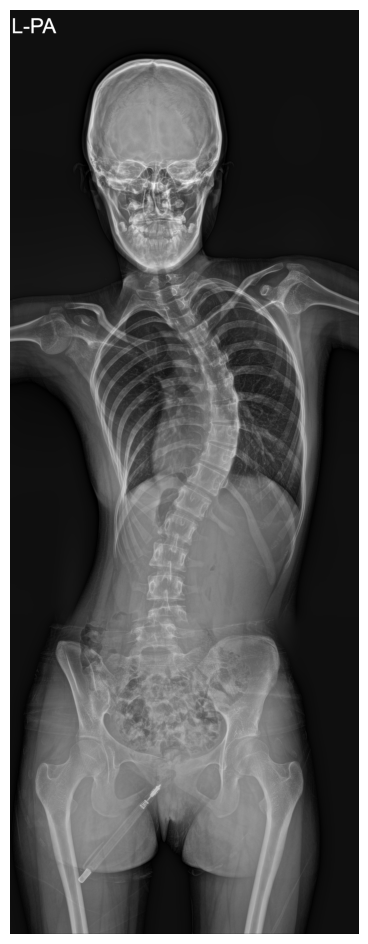

In [58]:
# Visualize Cobb Angles
import matplotlib.pyplot as plt

image = IMAGE

for mp_line in mid_points:
  image = cv.line(image, mp_line[0], mp_line[1], (0, 255, 0), 2)

# # Draw PT
top, bot = angles_with_pos['pt']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (0,255,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (0,255,255), 5)

# Draw TL
top, bot = angles_with_pos['tl']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (255,0,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (255,0,255), 5)

# Draw MT
top, bot = angles_with_pos['mt']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (0,0,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (0,0,255), 5)

print("Curve Type:",curve_type)
print("Angles:",cobb_angles)
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(image)

### With the **Keypoint RCNN Model**

In [59]:
import torch
import torchvision
from torchvision.transforms import functional as F
import numpy as np
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision

def _open_image_path(path):
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  img = F.to_tensor(img)
  return img

def _filter_output(output):
  # 1. Get Scores
  scores = output['scores'].detach().cpu().numpy()

  # 2. Get Indices of Scores over Threshold
  high_scores_idxs = np.where(scores > 0.5)[0].tolist() # Indexes of boxes with scores > 0.5

  # 3. Get Indices after Non-max Suppression
  post_nms_idxs = torchvision.ops.nms(output['boxes'][high_scores_idxs], output['scores'][high_scores_idxs], 0.3).cpu().numpy() # Indexes of boxes left after applying NMS (iou_threshold=0.3)

  # 4. Get final `bboxes` and `keypoints` and `scores` based on indices
  np_keypoints = output['keypoints'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
  np_bboxes = output['boxes'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()
  np_scores = output['scores'][high_scores_idxs][post_nms_idxs].detach().cpu().numpy()

  # 5. Get the Top 17 Scores
  sorted_scores_idxs = np.argsort(-1*np_scores) # descending

  np_scores = scores[sorted_scores_idxs][:18]
  np_keypoints = np.array([np_keypoints[idx] for idx in sorted_scores_idxs])[:18]
  np_bboxes = np.array([np_bboxes[idx] for idx in sorted_scores_idxs])[:18]

  # 6. Sort by ymin
  # kp[0] is the first point in [p1,p2,p3,p4]
  # kp[0][1] is the y1 in p1=[x1,y1,x2,y2]
  ymins = np.array([kps[0][1] for kps in np_keypoints])

  sorted_ymin_idxs = np.argsort(ymins) # ascending

  np_scores = np.array([np_scores[idx] for idx in sorted_ymin_idxs])
  np_keypoints = np.array([np_keypoints[idx] for idx in sorted_ymin_idxs])
  np_bboxes = np.array([np_bboxes[idx] for idx in sorted_ymin_idxs])

  # 7. Convert everything to List Instead of Numpy
  keypoints_list = []
  for kps in np_keypoints:
      keypoints_list.append([list(map(float, kp[:2])) for kp in kps])

  bboxes_list = []
  for bbox in np_bboxes:
      bboxes_list.append(list(map(int, bbox.tolist())))

  scores_list = np_scores.tolist()

  return bboxes_list, keypoints_list, scores_list

def predict(images):
  """
  images:
    > List of Tensors, shape=[C, W, H]. Values 0-1. |
    > Numpy array of image |
    > String path to image |
    > List of String paths to images

    returns (bboxes, keypoints, scores)[] of n=17
  """
  # 1. Process `images`
  if isinstance(images, list):
    if (type(images[0]) == str):
      images_input = [_open_image_path(path) for path in images]
  elif isinstance(images, np.ndarray):
    print("A numpy array")
    images_input = [F.to_tensor(images)]

  images_input = [image.to(device) for image in images_input]

  # 2. Inference
  with torch.no_grad():
    outputs = model(images_input) # 3. get output

  filtered_outputs = [_filter_output(output) for output in outputs]
  return filtered_outputs

def kprcnn_to_scoliovis_api_format(bboxes, keypoints, scores):
  """
  detections: Array(17)
  { class: number, confidence: number, name: "vert", xmax: number, xmin: number, ymin: number, ymax: number }
  normalized_detections: Array(17)
  landmarks: Array(136)
  """
  detections = []
  for idx, bbox in enumerate(bboxes):
    detections.append({
        "class": 0,
        "confidence": scores[idx],
        "name": "vert",
        "xmin": bbox[0],
        "ymin": bbox[1],
        "xmax": bbox[2],
        "ymax": bbox[3],
    })
  landmarks = []
  for kps in keypoints:
    for kp in kps:
      landmarks.append(kp[0])
      landmarks.append(kp[1])

  return {
      "detections": detections,
      "landmarks": landmarks
  }

def get_kprcnn_model(path):
    num_keypoints = 4
    anchor_generator = AnchorGenerator(sizes=(32, 64, 128, 256, 512), aspect_ratios=(0.25, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0))
    model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=False,
                                                                   pretrained_backbone=True,
                                                                   num_keypoints=num_keypoints,
                                                                   num_classes = 2, # Background is the first class, object is the second class
                                                                   rpn_anchor_generator=anchor_generator)
    if path:
        state_dict = torch.load(path, map_location=torch.device('cpu'), weights_only=False)
        model.load_state_dict(state_dict)

    return model

In [60]:
# 1. Load Model
device = torch.device('cuda')
model = get_kprcnn_model('./models/some-model-ep10.pt')
model.to(device)
model.eval()

# 2. Load & Preprocess Input
import os

image_names = sorted(os.listdir("./datasets/labeldata/data/test"))
test_sample_idx = 2
X = cv.cvtColor(cv.imread(f"./datasets/labeldata/data/test/{image_names[test_sample_idx]}"), cv.COLOR_BGR2RGB)
H, W = X.shape[0], X.shape[1]

results = predict(X)

c:\Users\USER\anaconda3\envs\scoliosis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\scoliosis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
c:\Users\USER\anaconda3\envs\scoliosis\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
c:\Users\USER\anaconda3\envs\scoliosis\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and 

A numpy array


In [61]:
bboxes, keypoints, scores = results[0]

# 3. Convert Keypoints to Format for cobb_angle_cal()
x_points = []
for kps in keypoints:
  for kp in kps:
    x_points.append(kp[0])

y_points = []
for kps in keypoints:
  for kp in kps:
    y_points.append(kp[1])

landmark_xy = x_points + y_points

Curve Type: S
Angles: [44.56082510917679, 1.2640925528200617, 31.50499831025407]


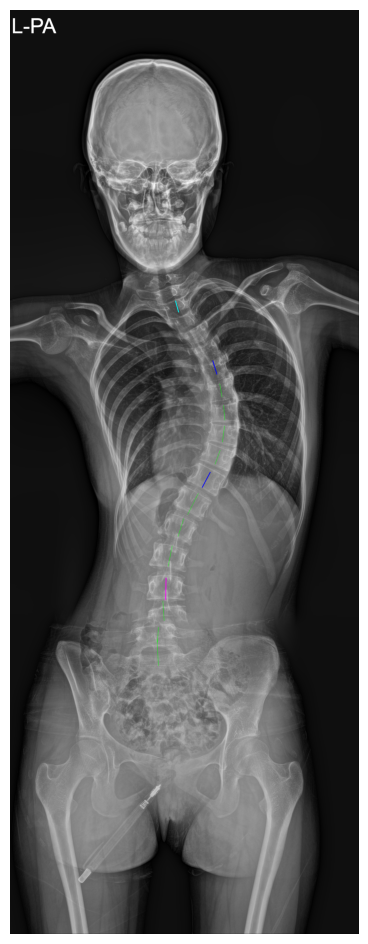

In [62]:
# 4. Call the Cobb Angle Calculation and Visualize
cobb_results = cobb_angle_cal(landmark_xy, X.shape)
cobb_angles, angles_with_pos, curve_type, mid_points = cobb_results

# Visualize Cobb Angles
import matplotlib.pyplot as plt

image = X

for mp_line in mid_points:
  image = cv.line(image, mp_line[0], mp_line[1], (0, 255, 0), 2)

# # Draw PT
top, bot = angles_with_pos['pt']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (0,255,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (0,255,255), 5)

# Draw TL
top, bot = angles_with_pos['tl']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (255,0,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (255,0,255), 5)

# Draw MT
top, bot = angles_with_pos['mt']['idxs']
image = cv.line(image, mid_points[top][0], mid_points[top][1], (0,0,255), 5)
image = cv.line(image, mid_points[bot][0], mid_points[bot][1], (0,0,255), 5)

print("Curve Type:",curve_type)
print("Angles:",cobb_angles)
plt.figure(figsize=(12,12))
plt.axis("off")
plt.imshow(image)

### Evaluating the Cobb Angle Measurement Algorithm

In [63]:
# 1. Load Model
device = torch.device('cuda')
model = get_kprcnn_model('./models/some-model-ep10.pt')
model.to(device)
model.eval()
None

In [64]:
# 2. Load & Preprocess Input
import os
import pandas as pd

image_names = sorted(os.listdir("./datasets/labeldata/data/test"))
X_list = []
for image_name in image_names:
  X_list.append(cv.cvtColor(cv.imread(f"./datasets/labeldata/data/test/{image_name}"), cv.COLOR_BGR2RGB))

In [65]:
# 3. Predict on Every Input
predicted_keypoints = []
for X in X_list:
  bboxes, keypoints, scores = predict(X)[0]
  predicted_keypoints.append(keypoints)

A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array
A numpy array


In [66]:
# 4. Convert Keypoints to Format for cobb_angle_cal()
landmark_xy_list = []
for predicted_keypoint in predicted_keypoints:
  landmark_xy_list.append(keypoints_to_landmark_xy(predicted_keypoint))

In [67]:
len(landmark_xy_list[5])

128

In [68]:
cobb_angles_dict = {}
for i, landmark_xy in enumerate(landmark_xy_list):
  # if (i in [20, 92, 94, 97, 107, 117]):
  #   continue
  c, _, _, _ = cobb_angle_cal(landmark_xy_list[i], X_list[i].shape)
  cobb_angles_dict[i] = c

AxisError: axis 1 is out of bounds for array of dimension 1

In [ ]:
import csv

with open('cobb_predictions.csv', 'w') as f:
  writer = csv.writer(f)
  for i in range(len(X_list)):
    if i in cobb_angles_dict.keys():
      writer.writerow(cobb_angles_dict[i])
    else:
      writer.writerow(['nan','nan','nan'])